# Machine Learning Essentials SS25 - Exercise Sheet 2

## Instructions
- `TODO`'s indicate where you need to complete the implementations.
- You may use external resources, but <b>write your own solutions</b>.
- Provide concise, but comprehensible comments to explain what your code does.
- Code that's unnecessarily extensive and/or not well commented will not be scored.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from scipy.stats import multivariate_normal
np.random.seed(42)

## Exercise 1 - Part 2

### Task 2a

In [2]:
muA = np.array([-1.0, -1.0])
muB = np.array([1.0, 1.0])
SigmaA = np.array([[1.0, 0.3],
                  [0.3, 1.0]])
SigmaB = np.array([[1.5, -0.2],
                  [-0.2, 1.5]])

piA, piB = 0.5, 0.5

# Inverses
invA = np.linalg.inv(SigmaA)
invB = np.linalg.inv(SigmaB)

# QDA parameters
Lambda = -0.5 * (invA - invB)
w_qda = invA.dot(muA) - invB.dot(muB)
b_qda = (
    -0.5 * (muA.T.dot(invA).dot(muA) - muB.T.dot(invB).dot(muB))
    -0.5 * np.log(np.linalg.det(SigmaA) / np.linalg.det(SigmaB))
    + np.log(piA / piB)
)

# LDA parameters
Sigma_pooled = 0.5 * (SigmaA + SigmaB)
inv_pooled = np.linalg.inv(Sigma_pooled)
w_lda = inv_pooled.dot(muA - muB)
b_lda = (
    -0.5 * muA.T.dot(inv_pooled).dot(muA) + 0.5 * muB.T.dot(inv_pooled).dot(muB)
    + np.log(piA / piB)
)

print("QDA parameters:")
print("Lambda:\n", Lambda)
print("w_qda:\n", w_qda)
print("b_qda:\n", b_qda)
print("\nLDA parameters:")
print("w_lda:\n", w_lda)
print("b_lda:\n", b_lda)

QDA parameters:
Lambda:
 [[-0.21008403  0.21008403]
 [ 0.21008403 -0.21008403]]
w_qda:
 [-1.53846154 -1.53846154]
b_qda:
 0.44365159750045136

LDA parameters:
w_lda:
 [-1.53846154 -1.53846154]
b_lda:
 0.0


### Task 2b

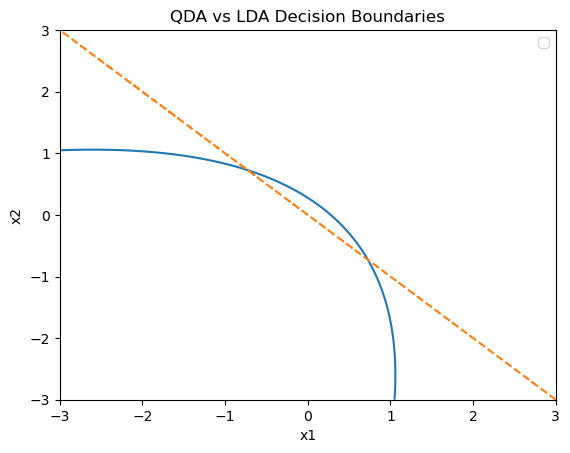

In [3]:
invP = np.linalg.inv(Sigma_pooled)
def g_qda(x):
    return (-0.5*np.log(np.linalg.det(SigmaA))
            -0.5*(x-muA)@invA@(x-muA)
            +np.log(piA)
            ) - (
            -0.5*np.log(np.linalg.det(SigmaB))
            -0.5*(x-muB)@invB@(x-muB)
            +np.log(piB)
            )

def g_lda(x):
    w = invP@(muA-muB)
    b = -0.5*(muA@invP@muA - muB@invP@muB) + np.log(piA/piB)
    return w@x + b

xs = np.linspace(-3,3,400)
ys = np.linspace(-3,3,400)
X, Y = np.meshgrid(xs, ys)
Z_qda = np.array([g_qda([x,y]) for x,y in zip(X.ravel(), Y.ravel())]).reshape(X.shape)
Z_lda = np.array([g_lda([x,y]) for x,y in zip(X.ravel(), Y.ravel())]).reshape(X.shape)

# Plot
plt.contour(X, Y, Z_qda, levels=[0], colors='C0')
plt.contour(X, Y, Z_lda, levels=[0], linestyles='--', colors='C1')
plt.xlabel('x1')
plt.ylabel('x2')
plt.legend(['QDA', 'LDA'])
plt.title('QDA vs LDA Decision Boundaries')
plt.show()

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import KFold
from scipy.stats import multivariate_normal
np.random.seed(42)

## Exercise 2 - Implementing LDA

### Task 1

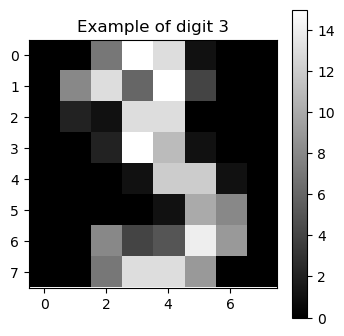

In [5]:
# TODO: Load digits dataset, visualize one example image of digit 3
digits = load_digits()
X, y = digits.data, digits.target

digit_3_indices = np.where(y == 3)[0]
example_3_idx = digit_3_indices[0]  # Take the first occurrence

example_3 = X[example_3_idx].reshape(8, 8)
plt.figure(figsize=(4, 4))
plt.imshow(example_3, cmap='gray', interpolation='nearest')
plt.title(f"Example of digit 3")
plt.colorbar()
plt.show()



### Task 2

In [6]:
# TODO: Filter the dataset to keep only digits 3 and 9, split into training and test set (train/test = 3/2)
mask_3_9 = np.logical_or(y == 3, y == 9)
X_filtered = X[mask_3_9]
y_filtered = y[mask_3_9]

# Transform labels to binary (3 -> -1, 9 -> 1)
y_binary = np.where(y_filtered == 3, -1, 1)

# Split the data with ratio 3:2 for train:test
X_train, X_test, y_train, y_test = train_test_split(
    X_filtered, y_binary, test_size=0.4, random_state=42
)

print(f"Number of samples for digit 3: {np.sum(y_binary == -1)}")
print(f"Number of samples for digit 9: {np.sum(y_binary == 1)}")
print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")


Number of samples for digit 3: 183
Number of samples for digit 9: 180
Training set size: 217
Test set size: 146


### Task 3

In [7]:
def features_2d(x):
    """
    This function takes the 64x1 feature vectors and returns a 2D representation of the data.
    """
    # Select the two most discriminative features based on variance
    feature_variances = np.var(X_train, axis=0)  # Compute variance for each feature
    most_discriminative_indices = np.argsort(feature_variances)[-2:]  # Get indices of top 2 features
    
    feature1 = x[:, most_discriminative_indices[0]]
    feature2 = x[:, most_discriminative_indices[1]]
    
    return np.column_stack((feature1, feature2))

# Create an embedded dataset using the selected features
X_train_2d = features_2d(X_train)
X_test_2d = features_2d(X_test)

print(f"Shape of transformed training data: {X_train_2d.shape}")
print(f"Shape of transformed test data: {X_test_2d.shape}")

Shape of transformed training data: (217, 2)
Shape of transformed test data: (146, 2)


### Task 4

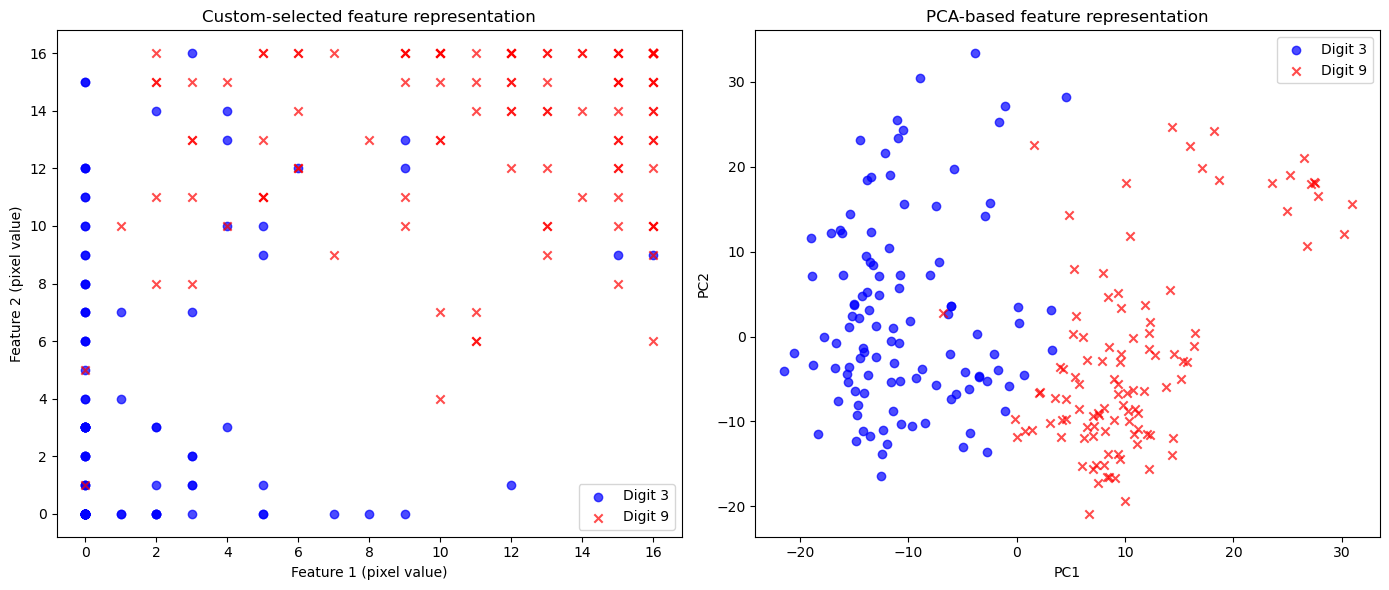

In [8]:
def pca_rep(x):
    """
    This function takes the 64x1 feature vectors and returns a 2D representation of the data. It uses PCA to reduce the dimensionality of the data to 2. PCA is a widely used algorithm for dimensionality reduction. Intuitively, PCA finds the directions in which the data varies the most and projects the data onto these directions.
    """
    # Standardize the data
    pca = PCA(n_components=2)
    return pca.fit_transform(x)

# TODO: Create a PCA-embedded dataset. Visualize & compare the embeddings. Briefly discuss the differences in separation achieved by the embeddings.
pca = PCA(n_components=2)
pca.fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

# Plot both feature representations
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
for label, marker, color in zip([-1, 1], ['o', 'x'], ['blue', 'red']):
    plt.scatter(
        X_train_2d[y_train == label, 0],
        X_train_2d[y_train == label, 1],
        marker=marker,
        color=color,
        alpha=0.7,
        label=f'Digit {"3" if label == -1 else "9"}'
    )
plt.title("Custom-selected feature representation")
plt.xlabel("Feature 1 (pixel value)")
plt.ylabel("Feature 2 (pixel value)")
plt.legend()

plt.subplot(1, 2, 2)
for label, marker, color in zip([-1, 1], ['o', 'x'], ['blue', 'red']):
    plt.scatter(
        X_train_pca[y_train == label, 0],
        X_train_pca[y_train == label, 1],
        marker=marker,
        color=color,
        alpha=0.7,
        label=f'Digit {"3" if label == -1 else "9"}'
    )
plt.title("PCA-based feature representation")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()

plt.tight_layout()
plt.show()



### Task 5

In [9]:
def fit_lda(training_features, training_labels):
    """
    Compute LDA parameters.
    """
    # TODO: Implement LDA
    # Filter out "dead" pixels (features with very low variance)
    variances = np.var(training_features, axis=0)
    active_indices = np.where(variances > 0.001)[0]
    features = training_features[:, active_indices]
    
    # Get unique classes
    classes = np.unique(training_labels)
    
    # Compute class means
    mu = {}
    for k in classes:
        mu[k] = np.mean(features[training_labels == k], axis=0)
    
    # Compute priors
    p = {}
    n_samples = features.shape[0]
    for k in classes:
        p[k] = np.sum(training_labels == k) / n_samples
    
    # Compute pooled covariance matrix
    covmat = np.zeros((features.shape[1], features.shape[1]))
    for k in classes:
        class_samples = features[training_labels == k]
        centered = class_samples - mu[k]
        covmat += centered.T @ centered
    
    covmat /= n_samples
    
    return mu, covmat, p, active_indices

# TODO: Fit seperate LDA models using your hand-crafted embedding, the PCA embedding, and the original data.
# Filter out dead pixels for the full dataset before fitting
X_train_filtered = X_train.copy()
X_test_filtered = X_test.copy()

# Fit LDA to the 3 different feature sets
mu_2d, covmat_2d, p_2d, active_indices_2d = fit_lda(X_train_2d, y_train)
mu_pca, covmat_pca, p_pca, active_indices_pca = fit_lda(X_train_pca, y_train)
mu_full, covmat_full, p_full, active_indices_full = fit_lda(X_train, y_train)

print(f"Number of active features in full dataset: {len(active_indices_full)}")
print(f"Shape of covariance matrix for full dataset: {covmat_full.shape}")

Number of active features in full dataset: 55
Shape of covariance matrix for full dataset: (55, 55)


### Task 6

In [10]:
def predict_lda(mu, covmat, p, test_features):
    """
    Predict labels using the LDA decision rule.
    """
    # TODO: Implement the LDA decision rule
    try:
        precision_matrix = np.linalg.inv(covmat)
    except np.linalg.LinAlgError:
        # Add a small regularization if matrix is singular
        precision_matrix = np.linalg.inv(covmat + 1e-6 * np.eye(covmat.shape[0]))
    
    w = precision_matrix @ (mu[1] - mu[-1])
    
    b = -0.5 * (mu[1].T @ precision_matrix @ mu[1] - 
                mu[-1].T @ precision_matrix @ mu[-1]) + np.log(p[1] / p[-1])
    
    # Predict labels
    scores = test_features @ w + b
    predicted_labels = np.sign(scores)
    
    return predicted_labels

# TODO: Perform LDA on the filtered train sets of all 3 embeddings, evaluate on the respective test set. Report training and test error rates for all 3 embeddings. Error rate = 1 - accuracy.

#  Function to calculate error rate
def error_rate(y_true, y_pred):
    return np.mean(y_true != y_pred)

# Predict using our custom 2D features
X_train_2d_active = X_train_2d[:, active_indices_2d]
X_test_2d_active = X_test_2d[:, active_indices_2d]

y_train_pred_2d = predict_lda(mu_2d, covmat_2d, p_2d, X_train_2d_active)
y_test_pred_2d = predict_lda(mu_2d, covmat_2d, p_2d, X_test_2d_active)

train_error_2d = error_rate(y_train, y_train_pred_2d)
test_error_2d = error_rate(y_test, y_test_pred_2d)

# Predict using PCA features
X_train_pca_active = X_train_pca[:, active_indices_pca]
X_test_pca_active = X_test_pca[:, active_indices_pca]

y_train_pred_pca = predict_lda(mu_pca, covmat_pca, p_pca, X_train_pca_active)
y_test_pred_pca = predict_lda(mu_pca, covmat_pca, p_pca, X_test_pca_active)

train_error_pca = error_rate(y_train, y_train_pred_pca)
test_error_pca = error_rate(y_test, y_test_pred_pca)

# Predict using full feature set
X_train_full_active = X_train[:, active_indices_full]
X_test_full_active = X_test[:, active_indices_full]

y_train_pred_full = predict_lda(mu_full, covmat_full, p_full, X_train_full_active)
y_test_pred_full = predict_lda(mu_full, covmat_full, p_full, X_test_full_active)

train_error_full = error_rate(y_train, y_train_pred_full)
test_error_full = error_rate(y_test, y_test_pred_full)

print("\nError rates:")
print(f"Custom 2D features - Train: {train_error_2d:.4f}, Test: {test_error_2d:.4f}")
print(f"PCA features - Train: {train_error_pca:.4f}, Test: {test_error_pca:.4f}")
print(f"Full features - Train: {train_error_full:.4f}, Test: {test_error_full:.4f}")



Error rates:
Custom 2D features - Train: 0.0968, Test: 0.1096
PCA features - Train: 0.0369, Test: 0.0616
Full features - Train: 0.0046, Test: 0.0274


### Task 7

/var/folders/gl/m711nqcx42d81f7zr656_v600000gn/T/ipykernel_28106/2419692344.py:27: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(


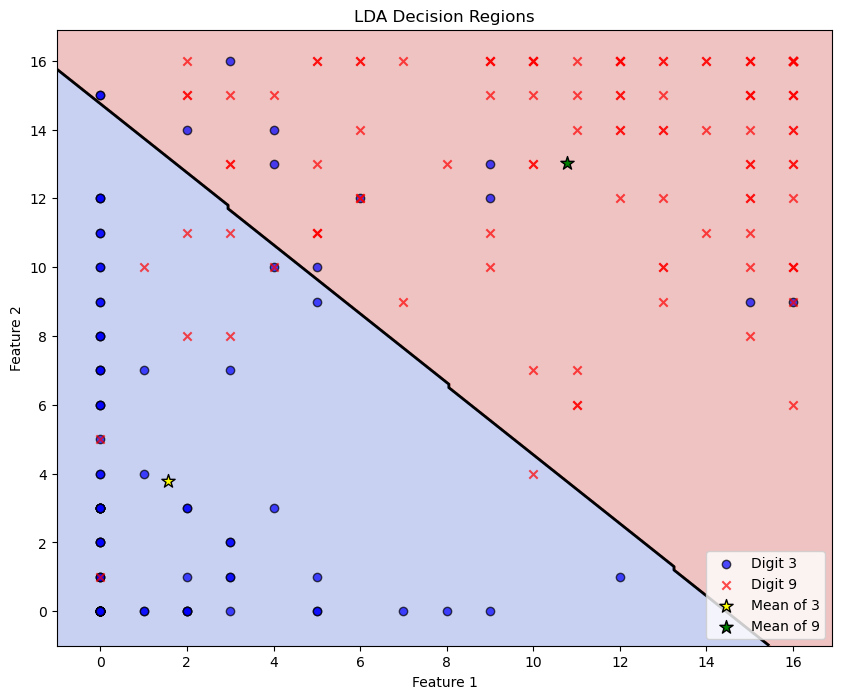

In [11]:
# TODO: For your hand-crafted embedding, visualize the decision boundary of the LDA classifier over a scatterplot of your data. Use a grid of points to visualize the decision boundary. Bonus: Visualize both Gaussian isocontours of the LDA model.
def plot_decision_regions(X, y, mu, covmat, p, active_indices):
    # Define grid boundaries
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    
    # Create a meshgrid
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                         np.arange(y_min, y_max, 0.1))
    
    # Flatten the grid points
    grid_points = np.c_[xx.ravel(), yy.ravel()]
    
    # Filter grid points based on active indices
    grid_points_active = grid_points[:, active_indices]
    
    # Predict classes for grid points
    Z = predict_lda(mu, covmat, p, grid_points_active)
    Z = Z.reshape(xx.shape)
    
    # Plot decision regions
    plt.figure(figsize=(10, 8))
    plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.coolwarm)
    
    # Plot scatter plot of training data
    for label, marker, color in zip([-1, 1], ['o', 'x'], ['blue', 'red']):
        plt.scatter(
            X[y == label, 0],
            X[y == label, 1],
            marker=marker,
            color=color,
            alpha=0.7,
            edgecolors='k',
            label=f'Digit {"3" if label == -1 else "9"}'
        )
    
    # Plot decision boundary
    plt.contour(xx, yy, Z, [0], linewidths=2, colors='black')
    
    # Plot class means
    for k in mu:
        if len(active_indices) > 0:
            plt.scatter(
                mu[k][0] if len(mu[k]) > 0 else 0,
                mu[k][1] if len(mu[k]) > 1 else 0,
                s=100,
                marker='*',
                color='yellow' if k == -1 else 'green',
                edgecolors='k',
                label=f'Mean of {"3" if k == -1 else "9"}'
            )
    
    plt.title('LDA Decision Regions')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend()
    plt.show()

# Plot decision regions for custom 2D features
plot_decision_regions(X_train_2d, y_train, mu_2d, covmat_2d, p_2d, active_indices_2d)



### Task 8

In [12]:
def cross_validate_lda(X, y, n_folds=10):
    # Filter out dead pixels for the full dataset
    variances = np.var(X, axis=0)
    active_indices = np.where(variances > 0.001)[0]
    X_active = X[:, active_indices]
    
    # Initialize cross-validation
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)
    errors = []
    
    # Perform cross-validation
    for train_idx, test_idx in kf.split(X_active):
        X_train_fold, X_test_fold = X_active[train_idx], X_active[test_idx]
        y_train_fold, y_test_fold = y[train_idx], y[test_idx]
        
        # Fit LDA
        mu, covmat, p, active_indices = fit_lda(X_train_fold, y_train_fold)
        
        # Predict
        # Ensure test data uses the same active features as training data
        X_test_fold_active = X_test_fold[:, active_indices]
        y_pred = predict_lda(mu, covmat, p, X_test_fold_active)
        
        # Calculate error
        error = error_rate(y_test_fold, y_pred)
        errors.append(error)
    
    # Calculate mean and standard error
    mean_error = np.mean(errors)
    std_error = np.std(errors) / np.sqrt(n_folds)
    
    return mean_error, std_error, errors

# Filter digits data to include only 3 and 9
digits_data = load_digits()
X_all, y_all = digits_data.data, digits_data.target
mask_3_9 = np.logical_or(y_all == 3, y_all == 9)
X_3_9 = X_all[mask_3_9]
y_3_9 = np.where(y_all[mask_3_9] == 3, -1, 1)

# Perform 10-fold cross-validation
cv_error, cv_std, all_errors = cross_validate_lda(X_3_9, y_3_9, n_folds=10)

print("\nCross-validation results:")
print(f"Mean error: {cv_error:.4f} ± {cv_std:.4f}")
print(f"Individual fold errors: {all_errors}")
print(f"Comparison with single train/test split error: {test_error_full:.4f}")



Cross-validation results:
Mean error: 0.0360 ± 0.0233
Individual fold errors: [np.float64(0.02702702702702703), np.float64(0.0), np.float64(0.0), np.float64(0.027777777777777776), np.float64(0.0), np.float64(0.05555555555555555), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.25)]
Comparison with single train/test split error: 0.0274


# Exercise 3: Statistical Darts

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

# Task 1: Simulate Dart Throws

In [14]:
def simulate_data(mu_true, Sigma_true, n_samples):
    return np.random.multivariate_normal(mu_true, Sigma_true, n_samples)

# Task 2: Compute MLE

In [15]:
def compute_mle(data):
    return np.mean(data, axis=0)

# Task 3: Compute Posterior and MAP

In [16]:
def compute_posterior(data, prior, Sigma_true):
    mu_0, Sigma_0 = prior
    N = data.shape[0]
    Sigma_true_inv = np.linalg.inv(Sigma_true)
    Sigma_0_inv = np.linalg.inv(Sigma_0)

    Sigma_post = np.linalg.inv(Sigma_0_inv + N * Sigma_true_inv)
    mu_mle = compute_mle(data)
    mu_post = Sigma_post @ (Sigma_0_inv @ mu_0 + N * Sigma_true_inv @ mu_mle)
    return mu_post, Sigma_post

def compute_map(data, prior, Sigma_true):
    mu_post, _ = compute_posterior(data, prior, Sigma_true)
    return mu_post

# Task 4: Visulization

In [17]:
def plot_cov_ellipse(mean, cov, ax, n_std=2.0, facecolor='none', edgecolor='black', label=''):
    vals, vecs = np.linalg.eigh(cov)
    order = vals.argsort()[::-1]
    vals, vecs = vals[order], vecs[:, order]
    theta = np.degrees(np.arctan2(*vecs[:, 0][::-1]))
    width, height = 2 * n_std * np.sqrt(vals)
    ellipse = Ellipse(xy=mean, width=width, height=height, angle=theta,
                      facecolor=facecolor, edgecolor=edgecolor, lw=2, label=label)
    ax.add_patch(ellipse)

def visualize_inference(mu_true, mu_mle, mu_map, mu_post, Sigma_post, data):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.scatter(data[:, 0], data[:, 1], color='gray', s=60, label='Throws', alpha=0.7)
    ax.scatter(*mu_true, color='green', marker='*', s=200, label='True aim (μ_true)')
    ax.scatter(*mu_mle, color='blue', marker='x', s=100, label='MLE')
    ax.scatter(*mu_map, color='red', marker='D', s=80, label='MAP')
    ax.scatter(*mu_post, color='orange', marker='o', s=100, label='Posterior mean (μ_post)')
    plot_cov_ellipse(mu_post, Sigma_post, ax, n_std=2, edgecolor='orange', label='Posterior 95% CI')
    ax.set_title("Dart Throw Inference Visualization", fontsize=14)
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.grid(True)
    ax.legend()
    ax.set_aspect('equal')
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
    plt.show()

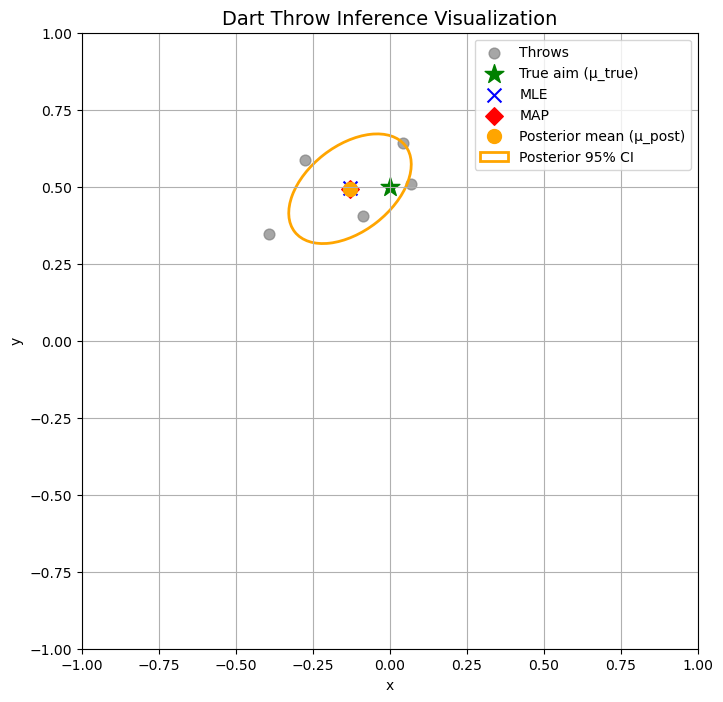

In [18]:
if __name__ == "__main__":
    np.random.seed(42)

    # True parameters
    mu_true = np.array([0.0, 0.5])
    Sigma_true = np.array([[0.05, 0.02],
                           [0.02, 0.04]])

    # Prior (standard normal around bullseye)
    mu_0 = np.array([0.0, 0.0])
    Sigma_0 = np.eye(2)
    prior = (mu_0, Sigma_0)

    # Simulate data
    N = 5  # number of throws
    data = simulate_data(mu_true, Sigma_true, N)

    # Perform inference
    mu_mle = compute_mle(data)
    mu_post, Sigma_post = compute_posterior(data, prior, Sigma_true)
    mu_map = compute_map(data, prior, Sigma_true)

    # Visualize results
    visualize_inference(mu_true, mu_mle, mu_map, mu_post, Sigma_post, data)
